# Image classification training with image format demo

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Prepare the data](#Prepare-the-data)
3. [Fine-tuning The Image Classification Model](#Fine-tuning-the-Image-classification-model)
  1. [Training parameters](#Training-parameters)
  2. [Start the training](#Start-the-training)
4. [Inference](#Inference)

## Introduction

Welcome to our end-to-end example of the image classification algorithm training with image format. In this demo, we will use the Amazon sagemaker image classification algorithm in transfer learning mode to fine-tune a pre-trained model (trained on imagenet data) to learn to classify a new dataset. In particular, the pre-trained model will be fine-tuned using [caltech-256 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech256/). 

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)

sess = sagemaker.Session()
bucket=sess.default_bucket() 
prefix = 'ic-lstformat'

arn:aws:iam::718498700052:role/service-role/AmazonSageMaker-ExecutionRole-20200407T110075
CPU times: user 967 ms, sys: 175 ms, total: 1.14 s
Wall time: 6.49 s


In [2]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
print (training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest



### Prepare the data
The caltech 256 dataset consist of images from 257 categories (the last one being a clutter category) and has 30k images with a minimum of 80 images and a maximum of about 800 images per category. 

The image classification algorithm can take two types of input formats. The first is a [RecordIO format](https://mxnet.incubator.apache.org/tutorials/basic/record_io.html) (content type: application/x-recordio) and the other is a [lst format](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec) (content type: application/x-image). Files for both these formats are available at http://data.dmlc.ml/mxnet/data/caltech-256/. In this example, we will use the lst format for training and use the training/validation split [specified here](http://data.dmlc.ml/mxnet/data/caltech-256/).

In [4]:
!sudo yum install unzip

Loaded plugins: dkms-build-requires, priorities, update-motd, upgrade-helper,
              : versionlock
amzn-main                                                | 2.1 kB     00:00     
amzn-updates                                             | 2.5 kB     00:00     
Package unzip-6.0-4.10.amzn1.x86_64 already installed and latest version
Nothing to do


In [7]:
import os
import urllib.request

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

# Tool for creating lst file
download('https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py')

In [9]:
%%bash

python im2rec.py --list --recursive google-adspolicy-images-train google-adspolicy-images/
python im2rec.py --list --recursive google-adspolicy-images-val google-adspolicy-images-20200510/

001.accept 0
002.decline 1
001.accept 0
002.decline 1


A .lst file is a tab-separated file with three columns that contains a list of image files. The first column specifies the image index, the second column specifies the class label index for the image, and the third column specifies the relative path of the image file. The image index in the first column should be unique across all of the images. Here we make an image list file using the [im2rec](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) tool from MXNet. You can also create the .lst file in your own way. An example of .lst file is shown as follows. 

In [10]:
!head -n 3 ./google-adspolicy-images-train.lst > example.lst
f = open('example.lst','r')
lst_content = f.read()
print(lst_content)

6123	1.000000	002.decline/1412333_R.jpg
4484	0.000000	001.accept/6718616_R.jpg
3499	0.000000	001.accept/5144497_R.jpg



When you are bringing your own image files to train, please ensure that the .lst file follows the same format as described above. In order to train with the lst format interface, passing the lst file for both training and validation in the appropriate format is mandatory. Once we have the data available in the correct format for training, the next step is to upload the image and .lst file to S3 bucket.

In [11]:
# Four channels: train, validation, train_lst, and validation_lst
s3train = 's3://{}/{}/train/'.format(bucket, prefix)
s3validation = 's3://{}/{}/validation/'.format(bucket, prefix)
s3train_lst = 's3://{}/{}/train_lst/'.format(bucket, prefix)
s3validation_lst = 's3://{}/{}/validation_lst/'.format(bucket, prefix)

# upload the image files to train and validation channels
!aws s3 cp google-adspolicy-images $s3train --recursive --quiet
!aws s3 cp google-adspolicy-images-20200510 $s3validation --recursive --quiet

# upload the lst files to train_lst and validation_lst channels
!aws s3 cp google-adspolicy-images-train.lst $s3train_lst --quiet
!aws s3 cp google-adspolicy-images-val.lst $s3validation_lst --quiet

Now we have all the data stored in S3 bucket. The image and lst files will be converted to RecordIO file internelly by the image classification algorithm. But if you want do the conversion, the following cell shows how to do it using the [im2rec](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) tool. Note that this is just an example of creating RecordIO files. We are **_not_** using them for training in this notebook. More details on creating RecordIO files can be found in this [tutorial](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec).

In [ ]:
%%bash
python im2rec.py --resize 256 --quality 9 --num-thread 16 caltech-256-60-val 256_ObjectCategories/
python im2rec.py --resize 256 --quality 90 --num-thread 16 caltech-256-60-train caltech_256_train_60/

After you created the RecordIO files, you can upload them to the train and validation channels for training. To train with RecordIO format, you can follow "[Image-classification-fulltraining.ipynb](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-fulltraining.ipynb)" and "[Image-classification-transfer-learning.ipynb](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-transfer-learning.ipynb)". Again, we will **_not_** use the RecordIO file for the training. The following sections will only show you how to train a model with images and list files.

Before training the model, we need to setup the training parameters. The next section will explain the parameters in detail.

## Fine-tuning the Image Classification Model
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.
### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Training instance count**: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings. 
* **Training instance type**: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training 
* **Output path**: This the s3 folder in which the training output is stored

In [12]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
ic = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
* **use_pretrained_model**: Set to 1 to use pretrained model for transfer learning.
* **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
* **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For caltech, we use 257 because it has 256 object categories + 1 clutter class.
* **num_training_samples**: This is the total number of training samples. It is set to 15240 for caltech dataset with the current split.
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run.
* **epochs**: Number of training epochs.
* **learning_rate**: Learning rate for training.
* **top_k**: Report the top-k accuracy during training.
* **resize**: Resize the image before using it for training. The images are resized so that the shortest side is of this parameter. If the parameter is not set, then the training data is used as such without resizing.
* **precision_dtype**: Training datatype precision (default: float32). If set to 'float16', the training will be done in mixed_precision mode and will be faster than float32 mode


In [13]:
ic.set_hyperparameters(num_layers=50,
                             use_pretrained_model=1,
                             image_shape = "3,224,224",
                             num_classes=3,
                             mini_batch_size=128,
                             epochs=5,
                             learning_rate=0.01,
                             top_k=2,
                             num_training_samples=10839,
                             resize = 256,
                             precision_dtype='float32')

## Input data specification
Set the data type and channels used for training

In [14]:
train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
train_data_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_lst': train_data_lst, 'validation_lst': validation_data_lst}

## Start the training
Start training by calling the fit method in the estimator

In [15]:
ic.fit(inputs=data_channels, logs=True, wait=False)

# Inference

***

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document. You can deploy the created model by using the deploy method in the estimator

In [16]:
ic_classifier = ic.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

-----------------!

#### Download test image

--2020-05-23 13:41:33--  https://live.staticflickr.com/4/3083/2487253502_1cd6d00f93_z.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 52.85.148.96, 2600:9000:20aa:7000:0:5a51:64c9:c681, 2600:9000:20aa:7600:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|52.85.148.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg           [ <=>                ]  75.12K  --.-KB/s    in 0.001s  

2020-05-23 13:41:33 (64.9 MB/s) - ‘/tmp/test.jpg’ saved [76923]



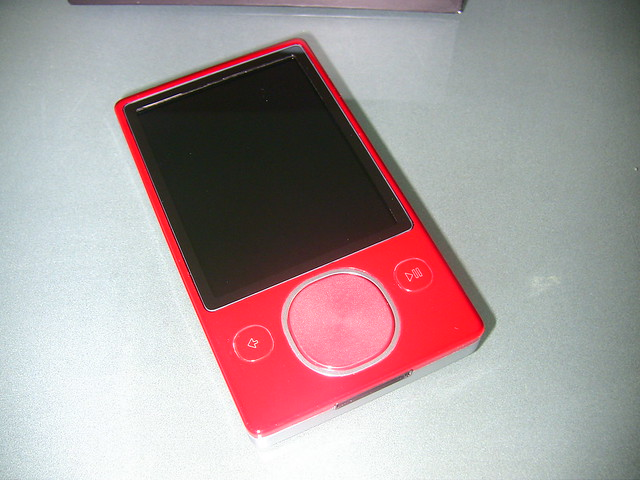

In [18]:
!wget -O /tmp/test.jpg https://live.staticflickr.com/4/3083/2487253502_1cd6d00f93_z.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  

In [19]:
import json
import numpy as np

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
    
ic_classifier.content_type = 'application/x-image'
result = json.loads(ic_classifier.predict(payload))
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['accept','decline']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - accept, probability - 0.8768200278282166


#### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released.

In [20]:
ic_classifier.delete_endpoint()